In [1]:
# Colab cell 1
!pip install -q fastapi uvicorn[standard] pyngrok joblib sentence-transformers lifelines scikit-learn flask nest_asyncio

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 349.3/349.3 kB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.3/117.3 kB 9.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 517.7/517.7 kB 16.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.4/4.4 MB 68.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 456.8/456.8 kB 32.8 MB/s eta 0:00:00


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# imports
import os
from pathlib import Path
import joblib
import json
import numpy as np
import pandas as pd
from typing import Optional
import nest_asyncio
nest_asyncio.apply()

In [4]:
# webserver libs
from fastapi import FastAPI
from pydantic import BaseModel
import uvicorn
from pyngrok import ngrok

In [5]:
# NLP/ML libs
from sentence_transformers import SentenceTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
# import lifelines (for survival model)
from lifelines import CoxPHFitter

In [6]:
# similarity
from sklearn.metrics.pairwise import cosine_similarity

In [8]:
import pandas as pd

main_df = pd.read_csv("/content/drive/My Drive/Secure-Result/Datasets/student_complaints_lean.csv")
print(main_df.head())

   Complaint ID         Complaint Type  \
0             1         Marks Mismatch   
1             2          Missing Grade   
2             3         Marks Mismatch   
3             4  Incorrect Calculation   
4             5         Absentee Error   

                                      Complaint Text Complaint Status  \
0        My midterm marks seem incorrect in Physics.          Pending   
1    My grade for Course X is missing in the portal.         Resolved   
2        My midterm marks seem incorrect in Physics.          Pending   
3  There appears to be a calculation error in my ...      In Progress   
4     I was marked absent for Lab despite attending.          Pending   

   Complaint Resolution Time Student ID         Student Program Student Year  \
0                          0   STD77951  Electrical Engineering          3rd   
1                          3   STD66907  Mechanical Engineering          4th   
2                          0   STD19911        Computer Science     

In [9]:
resolved_df = pd.read_csv("/content/drive/My Drive/Secure-Result/Datasets/resolved_complaints_dataset.csv")
print(resolved_df.head())

   Complaint ID  Complaint Type  \
0             2  Absentee Error   
1             7  Marks Mismatch   
2             8  Marks Mismatch   
3             9  Marks Mismatch   
4            10   Missing Grade   

                                    Complaint Text Complaint Status  \
0  I was marked absent for Exam despite attending.         Resolved   
1      My midterm marks seem incorrect in Physics.         Resolved   
2       My quiz marks seem incorrect in Chemistry.         Resolved   
3         My midterm marks seem incorrect in Math.         Resolved   
4  My grade for Course Y is missing in the portal.         Resolved   

   Complaint Resolution Time Student ID         Student Program Student Year  \
0                         10   STD46047        Computer Science          4th   
1                          3   STD63704  Electrical Engineering          4th   
2                          5   STD84895  Electrical Engineering          2nd   
3                          4   STD36915   

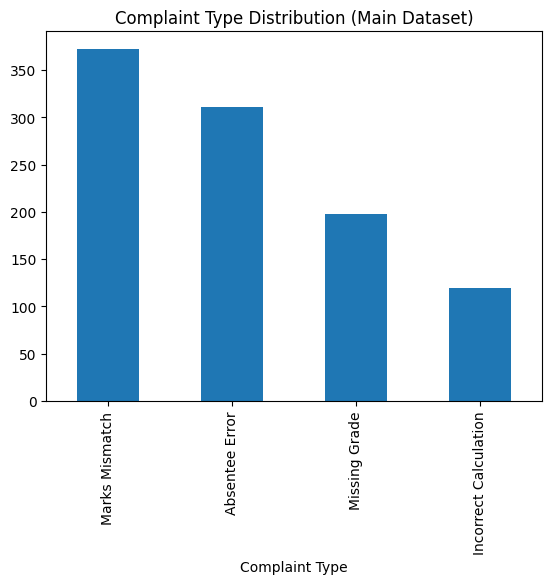

In [10]:
import matplotlib.pyplot as plt

main_df["Complaint Type"].value_counts().plot(kind="bar")
plt.title("Complaint Type Distribution (Main Dataset)")
plt.show()

In [31]:
resolved_df.rename(columns={"Complaint Resolution Time": "Resolution Time"}, inplace=True)

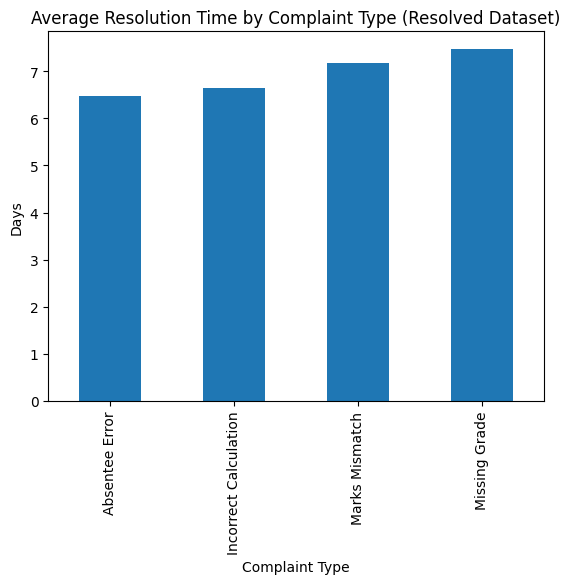

In [32]:
resolved_df.groupby("Complaint Type")["Resolution Time"].mean().plot(kind="bar")
plt.title("Average Resolution Time by Complaint Type (Resolved Dataset)")
plt.ylabel("Days")
plt.show()

In [33]:
import seaborn as sns

/tmp/ipython-input-1973348440.py:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x="Student Satisfaction Score", data=resolved_df, palette="mako")


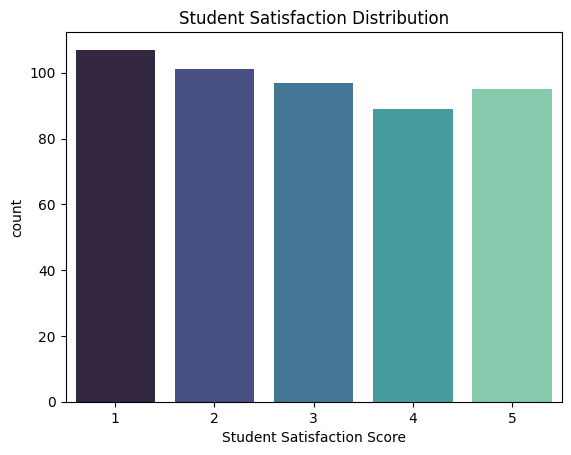

In [34]:
sns.countplot(x="Student Satisfaction Score", data=resolved_df, palette="mako")
plt.title("Student Satisfaction Distribution")
plt.show()

Preprocessing

Cleaning text and encoding categories.

In [35]:
import re
from nltk.corpus import stopwords
import nltk
nltk.download('stopwords')
stop = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [36]:
def clean_text(text):
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    text = text.lower()
    text = " ".join(word for word in text.split() if word not in stop)
    return text

main_df["Cleaned Complaint Text"] = main_df["Complaint Text"].apply(clean_text)
resolved_df["Cleaned Complaint Text"] = resolved_df["Complaint Text"].apply(clean_text)

from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
main_df["Complaint Type Encoded"] = le.fit_transform(main_df["Complaint Type"])
resolved_df["Complaint Type Encoded"] = le.transform(resolved_df["Complaint Type"])

In [37]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import precision_score, accuracy_score
import numpy as np

Model 1 – Complaint Type Classifier (Text to Type)

training a TF-IDF + Naive Bayes model.

In [38]:
vectorizer = TfidfVectorizer(max_features=1000)
X = vectorizer.fit_transform(main_df["Cleaned Complaint Text"])
y = main_df["Complaint Type Encoded"]

In [39]:
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.15, random_state=42, stratify=y)

In [40]:
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.1765, random_state=42, stratify=y_temp)

In [41]:
print(f"Train set size: {X_train.shape[0]}")

Train set size: 699


In [42]:
print(f"Validation set size: {X_val.shape[0]}")
print(f"Test set size: {X_test.shape[0]}")

Validation set size: 151
Test set size: 150


In [43]:
type_model = MultinomialNB()
type_model.fit(X_train, y_train)

MultinomialNB()

In [44]:
y_val_pred = type_model.predict(X_val)
val_precision = precision_score(y_val, y_val_pred, average='macro')
val_accuracy = accuracy_score(y_val, y_val_pred)

In [45]:
print("\n--- Validation Performance ---")
print(f"Precision (macro): {val_precision:.3f}")
print(f"Accuracy: {val_accuracy:.3f}")


--- Validation Performance ---
Precision (macro): 1.000
Accuracy: 1.000


In [46]:
y_test_pred = type_model.predict(X_test)
test_precision = precision_score(y_test, y_test_pred, average='macro')
test_accuracy = accuracy_score(y_test, y_test_pred)

In [47]:
print("\n--- Final Test Performance ---")
print(f"Precision (macro): {test_precision:.3f}")
print(f"Accuracy: {test_accuracy:.3f}")


--- Final Test Performance ---
Precision (macro): 1.000
Accuracy: 1.000


Model 2 – Duplicate Detection (Semantic Similarity)

using Sentence-BERT to find similar past resolved complaints and suggesting possible actions.

In [48]:
!pip install -q sentence-transformers

In [49]:
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import precision_score, accuracy_score
import numpy as np

In [28]:
model_sbert = SentenceTransformer("all-MiniLM-L6-v2")

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [50]:
resolved_embeddings = model_sbert.encode(resolved_df["Cleaned Complaint Text"].tolist())

def find_similar_complaint(new_complaint):
    new_cleaned = clean_text(new_complaint)
    new_emb = model_sbert.encode([new_cleaned])
    sims = cosine_similarity(new_emb, resolved_embeddings)
    idx = sims.argmax()
    return resolved_df.iloc[idx][["Complaint Type", "Complaint Text", "Resolution Description", "Resolution Time"]]

#example
test_query = "My grade for Course Y is missing in the portal."
print(find_similar_complaint(test_query))

Complaint Type                                                Missing Grade
Complaint Text              My grade for Course Y is missing in the portal.
Resolution Description    Added missing grade after consulting with the ...
Resolution Time                                                          13
Name: 10, dtype: object


In [51]:
from sklearn.metrics import precision_score, accuracy_score
from sklearn.preprocessing import LabelEncoder

In [52]:
val_texts = main_df.loc[y_val.index, "Cleaned Complaint Text"].tolist()
val_labels = main_df.loc[y_val.index, "Complaint Type"].tolist()

In [53]:
predicted_labels = []
for text in val_texts:
    sim_case = find_similar_complaint(text)
    predicted_labels.append(sim_case["Complaint Type"])

In [54]:
le_eval = LabelEncoder()
true_encoded = le_eval.fit_transform(val_labels)
pred_encoded = le_eval.transform(predicted_labels)

In [56]:
val_precision = precision_score(true_encoded, pred_encoded, average='macro')
val_accuracy = accuracy_score(true_encoded, pred_encoded)

In [57]:
print("\n--- Sentence-BERT Validation Performance ---")
print(f"Precision (macro): {val_precision:.3f}")
print(f"Accuracy: {val_accuracy:.3f}")


--- Sentence-BERT Validation Performance ---
Precision (macro): 1.000
Accuracy: 1.000


In [58]:
test_texts = main_df.loc[y_test.index, "Cleaned Complaint Text"].tolist()
test_labels = main_df.loc[y_test.index, "Complaint Type"].tolist()

In [59]:
predicted_test_labels = []
for text in test_texts:
    sim_case = find_similar_complaint(text)
    predicted_test_labels.append(sim_case["Complaint Type"])

In [60]:
true_test_encoded = le_eval.fit_transform(test_labels)
pred_test_encoded = le_eval.transform(predicted_test_labels)

In [61]:
test_precision = precision_score(true_test_encoded, pred_test_encoded, average='macro')
test_accuracy = accuracy_score(true_test_encoded, pred_test_encoded)

In [62]:
print("\n=== Sentence-BERT Test Performance ===")
print(f"Precision (macro): {test_precision:.3f}")
print(f"Accuracy: {test_accuracy:.3f}")


=== Sentence-BERT Test Performance ===
Precision (macro): 1.000
Accuracy: 1.000


In [64]:
joblib.dump(type_model, "/content/drive/MyDrive/Secure-Result/models/complaint_type_classifier.pkl")

['/content/drive/MyDrive/Secure-Result/models/complaint_type_classifier.pkl']

In [65]:
joblib.dump(vectorizer, "/content/drive/MyDrive/Secure-Result/models/tfidf_vectorizer.pkl")

['/content/drive/MyDrive/Secure-Result/models/tfidf_vectorizer.pkl']

In [66]:
model_sbert.save("/content/drive/MyDrive/Secure-Result/models/sbert_duplicate_model")

np.save("/content/drive/MyDrive/Secure-Result/models/resolved_embeddings.npy", resolved_embeddings)

resolved_df.to_csv(
    "/content/drive/MyDrive/Secure-Result/models/resolved_reference.csv",
    index=False
)

In [67]:
joblib.dump(le, "/content/drive/MyDrive/Secure-Result/models/label_encoder.pkl")

['/content/drive/MyDrive/Secure-Result/models/label_encoder.pkl']

File-3


In [68]:
X_text = vectorizer.transform(main_df["Cleaned Complaint Text"])

In [69]:
y_pred_type = type_model.predict(X_text)
main_df["Predicted Complaint Type"] = y_pred_type

In [71]:
display(main_df[["Complaint Text", "Complaint Type", "Predicted Complaint Type"]].head(10))

,Complaint Text,Complaint Type,Predicted Complaint Type
0,My midterm marks seem incorrect in Physics.,Marks Mismatch,2
1,My grade for Course X is missing in the portal.,Missing Grade,3
2,My midterm marks seem incorrect in Physics.,Marks Mismatch,2
3,There appears to be a calculation error in my ...,Incorrect Calculation,1
4,I was marked absent for Lab despite attending.,Absentee Error,0
5,My midterm marks seem incorrect in Math.,Marks Mismatch,2
6,I was marked absent for Exam despite attending.,Absentee Error,0
7,I was marked absent for Exam despite attending.,Absentee Error,0
8,There appears to be a calculation error in my ...,Incorrect Calculation,1
9,I was marked absent for Exam despite attending.,Absentee Error,0


SLA Prediction and SLA Breach Risk Score

In [72]:
!pip install lifelines

In [73]:
!pip install -q lifelines
from lifelines import CoxPHFitter
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, accuracy_score
from lifelines.utils import concordance_index
import numpy as np

In [74]:
resolved_df["SLA_Breached"] = (resolved_df["Resolution Time"] > 7).astype(int)
survival_data = resolved_df[["Resolution Time", "SLA_Breached", "Complaint Type"]]
print(survival_data.head())

   Resolution Time  SLA_Breached  Complaint Type
0               10             1  Absentee Error
1                3             0  Marks Mismatch
2                5             0  Marks Mismatch
3                4             0  Marks Mismatch
4                7             0   Missing Grade


In [75]:
from sklearn.model_selection import train_test_split
from lifelines.utils import concordance_index

In [76]:
encoded_df = pd.get_dummies(
    resolved_df[["Resolution Time", "SLA_Breached", "Complaint Type", "Faculty Department"]],
    columns=["Complaint Type", "Faculty Department"],
    drop_first=True
)

In [77]:
train_df, test_df = train_test_split(encoded_df, test_size=0.2, random_state=42)

In [78]:
cph = CoxPHFitter()
cph.fit(train_df, duration_col="Resolution Time", event_col="SLA_Breached")

<lifelines.CoxPHFitter: fitted with 391 total observations, 207 right-censored observations>

In [79]:
cph.print_summary()

<lifelines.CoxPHFitter: fitted with 391 total observations, 207 right-censored observations>
             duration col = 'Resolution Time'
                event col = 'SLA_Breached'
      baseline estimation = breslow
   number of observations = 391
number of events observed = 184
   partial log-likelihood = -777.10
         time fit was run = 2025-11-17 14:14:02 UTC

---
                                           coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                                                  
Complaint Type_Incorrect Calculation       0.19      1.21      0.29           -0.38            0.76                0.68                2.14
Complaint Type_Marks Mismatch              0.10      1.11      0.19           -0.27            0.47                0.76                1.61
Complaint Type_Missing Grade               0.16      1.17      0.22           -0.27            0.59                0.76                1.80
Faculty Department_Computer Science        0.09      1.10      0.23           -0.35            0.53                0.70                1.71
Faculty Department_Electrical Engineering  0.32      1.38      0.20           -0.06            0.71                0.94                2.03
Faculty Department_Mechanical Engineering  0.02      1.02      0.20           -0.38            0.42                0.68                1.52

                                           cmp to    z    p  -log2(p)
covariate                                                            
Complaint Type_Incorrect Calculation         0.00 0.65 0.52      0.95
Complaint Type_Marks Mismatch                0.00 0.53 0.60      0.75
Complaint Type_Missing Grade                 0.00 0.72 0.47      1.08
Faculty Department_Computer Science          0.00 0.41 0.68      0.55
Faculty Department_Electrical Engineering    0.00 1.65 0.10      3.34
Faculty Department_Mechanical Engineering    0.00 0.09 0.93      0.10
---
Concordance = 0.54
Partial AIC = 1566.20
log-likelihood ratio test = 3.95 on 6 df
-log2(p) of ll-ratio test = 0.55

In [80]:
train_pred = cph.predict_partial_hazard(train_df)
test_pred = cph.predict_partial_hazard(test_df)

In [81]:
c_index_train = concordance_index(train_df["Resolution Time"], -train_pred, train_df["SLA_Breached"])
c_index_test = concordance_index(test_df["Resolution Time"], -test_pred, test_df["SLA_Breached"])

In [82]:
print(f"\nConcordance Index (Train): {c_index_train:.3f}")
print(f"Concordance Index (Test): {c_index_test:.3f}")


Concordance Index (Train): 0.535
Concordance Index (Test): 0.451


Model 3 - SLA Resolution Time Prediction (median expected time)

In [83]:
feature_cols = [col for col in encoded_df.columns if col not in ["Resolution Time", "SLA_Breached"]]

In [84]:
resolved_df["Predicted_Median_Resolution_Time"] = cph.predict_median(encoded_df[feature_cols])
print("\nSample Predicted Resolution Times:")
print(resolved_df[["Complaint Type", "Resolution Time", "Predicted_Median_Resolution_Time"]].head())


Sample Predicted Resolution Times:
   Complaint Type  Resolution Time  Predicted_Median_Resolution_Time
0  Absentee Error               10                              11.0
1  Marks Mismatch                3                              11.0
2  Marks Mismatch                5                              11.0
3  Marks Mismatch                4                              11.0
4   Missing Grade                7                              11.0


Model 4 - SLA Breach Probability Prediction (P[T > 7])

In [85]:
feature_cols = [col for col in encoded_df.columns if col not in ["Resolution Time", "SLA_Breached"]]

In [86]:
survival_funcs = cph.predict_survival_function(encoded_df[feature_cols])

In [87]:
t_query = 7
if t_query in survival_funcs.index:
    p_breach = survival_funcs.loc[t_query].values
else:
    p_breach = np.interp(t_query, survival_funcs.index.values, survival_funcs.values)

In [88]:
resolved_df["SLA_Breach_Probability"] = p_breach

In [89]:
print("\nSample SLA Breach Probabilities:")
print(resolved_df[["Complaint Type", "Resolution Time", "SLA_Breach_Probability"]].head())


Sample SLA Breach Probabilities:
   Complaint Type  Resolution Time  SLA_Breach_Probability
0  Absentee Error               10                     1.0
1  Marks Mismatch                3                     1.0
2  Marks Mismatch                5                     1.0
3  Marks Mismatch                4                     1.0
4   Missing Grade                7                     1.0


In [90]:
encoded_df = pd.get_dummies(
    resolved_df[["Resolution Time", "SLA_Breached", "Complaint Type", "Faculty Department"]],
    columns=["Complaint Type", "Faculty Department"],
    drop_first=True
)

In [93]:
X = encoded_df.drop(columns=["SLA_Breached"])
y = encoded_df["SLA_Breached"]

In [94]:
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.15, random_state=42, stratify=y)

In [95]:
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.1765, random_state=42, stratify=y_temp)

In [96]:
print(f"Train set: {len(X_train)}, Validation: {len(X_val)}, Test: {len(X_test)}")

Train set: 341, Validation: 74, Test: 74


In [97]:
train_df = X_train.copy(); train_df["SLA_Breached"] = y_train
val_df = X_val.copy(); val_df["SLA_Breached"] = y_val
test_df = X_test.copy(); test_df["SLA_Breached"] = y_test

In [98]:
cph = CoxPHFitter()
cph.fit(train_df, duration_col="Resolution Time", event_col="SLA_Breached")

<lifelines.CoxPHFitter: fitted with 341 total observations, 180 right-censored observations>

In [99]:
feature_cols = [col for col in encoded_df.columns if col not in ["Resolution Time", "SLA_Breached"]]

In [100]:
resolved_df["Predicted_Median_Resolution_Time"] = cph.predict_median(encoded_df[feature_cols])

In [101]:
surv_funcs = cph.predict_survival_function(encoded_df[feature_cols])
t_query = 7
if t_query in surv_funcs.index:
    p_breach = surv_funcs.loc[t_query].values
else:
    p_breach = np.interp(t_query, surv_funcs.index.values, surv_funcs.values)
resolved_df["SLA_Breach_Probability"] = p_breach

In [102]:
threshold = 0.5
resolved_df["Predicted_SLA_Breach"] = (resolved_df["SLA_Breach_Probability"] >= threshold).astype(int)

In [103]:
val_idx = X_val.index
test_idx = X_test.index

In [104]:
val_precision = precision_score(y_val, resolved_df.loc[val_idx, "Predicted_SLA_Breach"], average='binary')
val_accuracy = accuracy_score(y_val, resolved_df.loc[val_idx, "Predicted_SLA_Breach"])

In [105]:
print("\n--- SLA Breach Validation Performance ---")
print(f"Precision: {val_precision:.3f}")
print(f"Accuracy: {val_accuracy:.3f}")


--- SLA Breach Validation Performance ---
Precision: 0.473
Accuracy: 0.473


In [106]:
test_precision = precision_score(y_test, resolved_df.loc[test_idx, "Predicted_SLA_Breach"], average='binary')
test_accuracy = accuracy_score(y_test, resolved_df.loc[test_idx, "Predicted_SLA_Breach"])

In [107]:
print("\n=== SLA Breach Test Performance ===")
print(f"Precision: {test_precision:.3f}")
print(f"Accuracy: {test_accuracy:.3f}")


=== SLA Breach Test Performance ===
Precision: 0.473
Accuracy: 0.473


Evaluate Binary SLA Breach Prediction Accuracy

In [108]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

In [109]:
resolved_df["Predicted_SLA_Breach"] = (resolved_df["SLA_Breach_Probability"] >= 0.5).astype(int)

In [110]:
print("\nSLA Breach Classification Performance (Threshold = 0.5):")
print(classification_report(resolved_df["SLA_Breached"], resolved_df["Predicted_SLA_Breach"]))


SLA Breach Classification Performance (Threshold = 0.5):
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       258
           1       0.47      1.00      0.64       231

    accuracy                           0.47       489
   macro avg       0.24      0.50      0.32       489
weighted avg       0.22      0.47      0.30       489



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


CoxPHFitter’s built-in interpretability

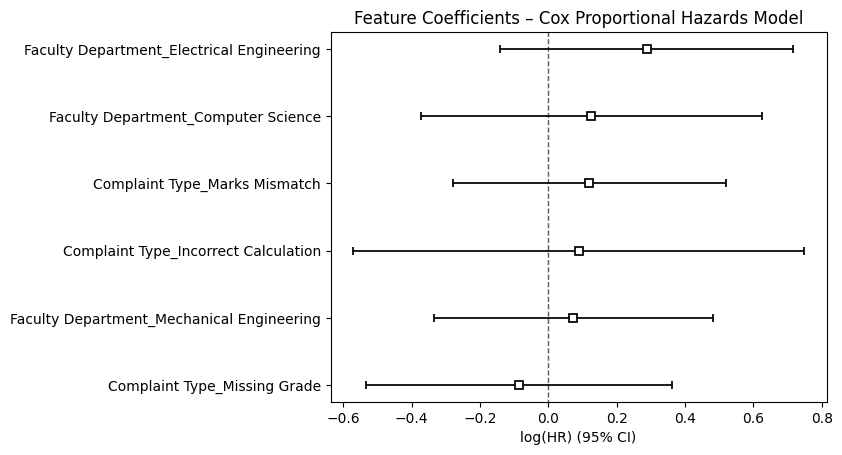

In [111]:
cph.plot()
plt.title("Feature Coefficients – Cox Proportional Hazards Model")
plt.show()

In [112]:
cph.print_summary()

<lifelines.CoxPHFitter: fitted with 341 total observations, 180 right-censored observations>
             duration col = 'Resolution Time'
                event col = 'SLA_Breached'
      baseline estimation = breslow
   number of observations = 341
number of events observed = 161
   partial log-likelihood = -659.04
         time fit was run = 2025-11-17 14:17:14 UTC

---
                                           coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                                                  
Complaint Type_Incorrect Calculation       0.09      1.09      0.34           -0.57            0.75                0.56                2.11
Complaint Type_Marks Mismatch              0.12      1.13      0.20           -0.28            0.52                0.76                1.68
Complaint Type_Missing Grade              -0.09      0.92      0.23           -0.53            0.36                0.59                1.44
Faculty Department_Computer Science        0.13      1.13      0.25           -0.37            0.62                0.69                1.87
Faculty Department_Electrical Engineering  0.29      1.33      0.22           -0.14            0.72                0.87                2.05
Faculty Department_Mechanical Engineering  0.07      1.08      0.21           -0.34            0.48                0.71                1.62

                                           cmp to     z    p  -log2(p)
covariate                                                             
Complaint Type_Incorrect Calculation         0.00  0.26 0.79      0.33
Complaint Type_Marks Mismatch                0.00  0.59 0.56      0.84
Complaint Type_Missing Grade                 0.00 -0.38 0.71      0.50
Faculty Department_Computer Science          0.00  0.49 0.62      0.69
Faculty Department_Electrical Engineering    0.00  1.31 0.19      2.40
Faculty Department_Mechanical Engineering    0.00  0.35 0.73      0.46
---
Concordance = 0.54
Partial AIC = 1330.08
log-likelihood ratio test = 3.05 on 6 df
-log2(p) of ll-ratio test = 0.32

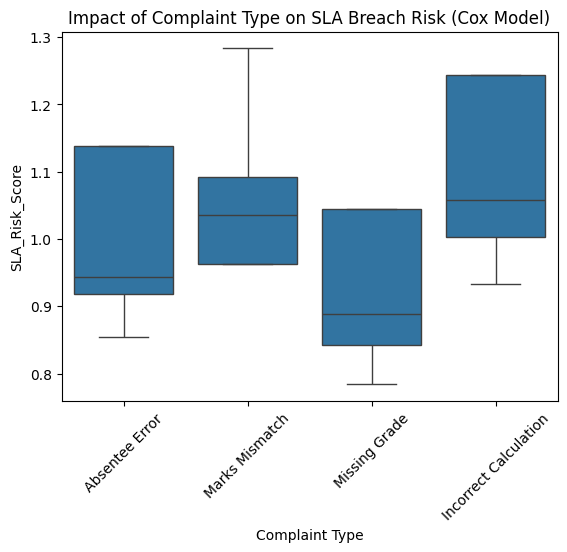

In [115]:
resolved_df["SLA_Risk_Score"] = cph.predict_partial_hazard(encoded_df[feature_cols])
sns.boxplot(x="Complaint Type", y="SLA_Risk_Score", data=resolved_df)
plt.title("Impact of Complaint Type on SLA Breach Risk (Cox Model)")
plt.xticks(rotation=45)
plt.show()

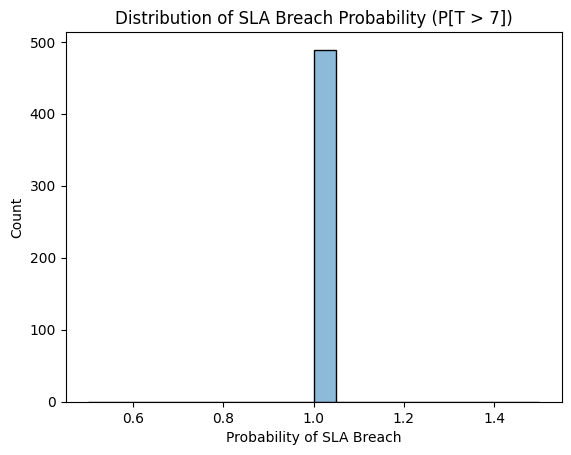

In [116]:
sns.histplot(resolved_df["SLA_Breach_Probability"], bins=20, kde=True)
plt.title("Distribution of SLA Breach Probability (P[T > 7])")
plt.xlabel("Probability of SLA Breach")
plt.show()

In [117]:
import joblib
joblib.dump(cph, "/content/drive/MyDrive/Secure-Result/models/sla_survival_model.pkl")

['/content/drive/MyDrive/Secure-Result/models/sla_survival_model.pkl']

In [118]:
import json

feature_cols = [col for col in encoded_df.columns if col not in ["Resolution Time", "SLA_Breached"]]

with open("/content/drive/MyDrive/Secure-Result/models/sla_features.json", "w") as f:
    json.dump(feature_cols, f)


Model 5 - Anomaly Detection (Isolation Forest)

flag unusual complaints based on numerical & categorical encodings.

This identifies complaints with unusual behavior (e.g., extremely long resolution time for a low-severity complaint).

In [119]:
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import IsolationForest
from sklearn.metrics import precision_score, accuracy_score

In [120]:
le_student_program = LabelEncoder()

In [121]:
main_df["Student Program Encoded"] = le_student_program.fit_transform(main_df["Student Program"])

In [122]:
le_faculty_department = LabelEncoder()

In [123]:
main_df["Faculty Department Encoded"] = le_faculty_department.fit_transform(main_df["Faculty Department"])

In [124]:
features = ["Complaint Resolution Time", "Student Program Encoded", "Faculty Department Encoded"]
iso = IsolationForest(contamination=0.05, random_state=42)
main_df["Anomaly Flag"] = iso.fit_predict(main_df[features])

In [125]:
main_df["Anomaly Flag"] = main_df["Anomaly Flag"] == -1

In [126]:
main_df["True_Anomaly"] = (main_df["Complaint Resolution Time"] > 10).astype(int)

In [127]:
X = main_df[features]
y = main_df["True_Anomaly"]

In [128]:
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.15, random_state=42, stratify=y)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.1765, random_state=42, stratify=y_temp)

In [129]:
print(f"Train: {len(X_train)}, Validation: {len(X_val)}, Test: {len(X_test)}")

Train: 699, Validation: 151, Test: 150


In [130]:
iso = IsolationForest(contamination=0.05, random_state=42)
iso.fit(X_train)

IsolationForest(contamination=0.05, random_state=42)

In [131]:
main_df.loc[X_train.index, "Anomaly_Pred"] = iso.predict(X_train)
main_df.loc[X_val.index, "Anomaly_Pred_Val"] = iso.predict(X_val)
main_df.loc[X_test.index, "Anomaly_Pred_Test"] = iso.predict(X_test)

In [132]:
main_df["Anomaly_Pred_Val"] = main_df["Anomaly_Pred_Val"].apply(lambda x: 1 if x == -1 else 0)
main_df["Anomaly_Pred_Test"] = main_df["Anomaly_Pred_Test"].apply(lambda x: 1 if x == -1 else 0)

In [133]:
val_precision = precision_score(y_val, main_df.loc[X_val.index, "Anomaly_Pred_Val"])
val_accuracy = accuracy_score(y_val, main_df.loc[X_val.index, "Anomaly_Pred_Val"])

In [134]:
print("\n--- Anomaly Detection Validation Performance ---")
print(f"Precision: {val_precision:.3f}")
print(f"Accuracy: {val_accuracy:.3f}")


--- Anomaly Detection Validation Performance ---
Precision: 0.545
Accuracy: 0.887


In [135]:
test_precision = precision_score(y_test, main_df.loc[X_test.index, "Anomaly_Pred_Test"])
test_accuracy = accuracy_score(y_test, main_df.loc[X_test.index, "Anomaly_Pred_Test"])

In [136]:
print("\n--- Anomaly Detection Test Performance ---")
print(f"Precision: {test_precision:.3f}")
print(f"Accuracy: {test_accuracy:.3f}")


--- Anomaly Detection Test Performance ---
Precision: 0.600
Accuracy: 0.893


In [137]:
display(main_df.loc[X_test.index, ["Complaint Text", "Complaint Resolution Time", "Anomaly_Pred_Test"]].head(10))

,Complaint Text,Complaint Resolution Time,Anomaly_Pred_Test
532,There appears to be a calculation error in my ...,6,0
551,My final marks seem incorrect in Physics.,8,0
737,My quiz marks seem incorrect in Chemistry.,12,0
860,My final marks seem incorrect in Math.,7,0
221,My final marks seem incorrect in Physics.,2,0
730,I was marked absent for Exam despite attending.,4,0
550,My final marks seem incorrect in Physics.,0,0
76,My quiz marks seem incorrect in Math.,3,0
236,My midterm marks seem incorrect in Chemistry.,5,0
868,I was marked absent for Exam despite attending.,3,0


In [138]:
joblib.dump(iso, "/content/drive/MyDrive/Secure-Result/models/anomaly_model.pkl")

['/content/drive/MyDrive/Secure-Result/models/anomaly_model.pkl']

In [139]:
joblib.dump(le_student_program, "/content/drive/MyDrive/Secure-Result/models/le_student_program.pkl")
joblib.dump(le_faculty_department, "/content/drive/MyDrive/Secure-Result/models/le_faculty_department.pkl")

['/content/drive/MyDrive/Secure-Result/models/le_faculty_department.pkl']